# Copy-Move Forgery Detection (CMFD)

*In this report, we study the subject of Copy-Move Forgery Detection, which aims to identify copy-moves of some parts of an image to another location in this same image . Starting from the PatchMatch algorithm introduced in [\[1\]](https://ieeexplore.ieee.org/document/7026075) and further studied in [\[2\]](https://ieeexplore.ieee.org/document/7154457), we reproduce the results reported in the article and test its robustness against different transformations of the copied patches. We finally propose a complementary method based on noise estimation to handle forgeries in some particular settings. We report good performance in terms of F1-score and computation speed, and also interesting first results for the detection of forgeries with patches coming from other images.*

## Introduction

Copy-Move forgery is a method which consists in copying patches of pixels in the image to another location in the same image. This can be notably used to hide elements, or to populate an image using replicates of already existing elements. Such practices belong to the family of methods around inpainting to fill a masked area with relevant content. In the following, we will restrict ourselves to methods using patches from the image and not producing inpainting from variatonal approaches (see [Bertalmio, Sapiro, Caselles, Ballester (2000)](https://www.researchgate.net/publication/220720382_Image_inpainting)), or relying on neural networks (see [Izuka et al.](http://iizuka.cs.tsukuba.ac.jp/projects/completion/data/completion_sig2017.pdf) for example).

<img src="example_images/iejov.jpg" width="500" />
<img src="example_images/staline.jpg" width="500" /> 

The aforementionned application cases motivate the need for elaborating methods to detect and localize forgeries in images in order to identify fake images for example, or understand the nature of missing parts.



## 1) Presentation of PatchMatch

The PatchMatch algorithm was introduced in [\[1\]](https://ieeexplore.ieee.org/document/7026075), and then further studied in [\[2\]](https://ieeexplore.ieee.org/document/7154457), to tackle the problematic of Copy-Move Forgery Detection in an efficient way. It follows three main steps which are classic in the literature on CMFD :
 - the computation of the features associated to each pixel
 - the matching between the pixels using the features
 - the filtering of the matches

The second and the third point were introduced in 2014 in [\[1\]](https://ieeexplore.ieee.org/document/7026075), whereas the study of the choice of the features was realized one year later in [\[2\]](https://ieeexplore.ieee.org/document/7154457). We will present the method following this chronological aspect.


### Matching

The matching stage in the PatchMatch algorithm aims to compute the nearest neighbour field (NNF) of an image $I$. We define this NNF as a field of displacements $f:I\rightarrow \mathbb{R}^2$ associating each pixel $z$ to the pixel $z+f(z)$which minimizes the distance between the patches $P(z)$ and $P(z+f(z))$ centered around these pixels.

$$
\begin{equation}
f(z) = \underset{\phi:z+\phi \in I}{\operatorname{argmin}} \operatorname{dist}\left( P(z), P(z+\phi) \right)
\end{equation}
$$

However, PatchMatch only computes an approximate NNF, since determining an exact NNF is computationnaly too expensive. The main idea behind this computation relies on the assumption that the NNF is locally regular on most pixels, which is motivated by the fact that most pixels are part of an item in the image, which is itself regular. Following this assumption, when a good displacement is found for a pixel, it is very likely that this displacement is also a good candidate for the neighbouring pixels. PatchMatch thus tries to propagate good displacements through the image by comparing the value of the NNF at a given pixel with its values at the neighbouring pixels. The NNF is updated if it improves the distance objective between the patches.

The equations below detail the update performed during the propagation step ($z^u,z^b,z^l,z^r$ denote the neighbouring pixel in the up, bottom, left and ight directions):
 - on even iterations, good displacements are propagated from the bootom-right of the image to the its top-left :
 $$
 \begin{equation}
     f(z) = \underset{z' \in \{z,z^u,z^l\}}{\operatorname{argmin}} \operatorname{dist}\left( P(z), P(z+f(z'))  \right)
 \end{equation}
 $$
 - on odd iterations, the propagation is made in the other directions to avoid biases :
 $$
 \begin{equation}
     f(z) = \underset{z' \in \{z,z^b,z^r\}}{\operatorname{argmin}} \operatorname{dist}\left( P(z), P(z+f(z'))  \right)
 \end{equation}
 $$

Finally, each propagation step is alternated with a step of update with random candidates to allow the discovery of new displacements and avoid being stuck in a local minimum.

We present below a synthetic pseudo-code of the basic PatchMatch algorithm for CMFD.

```
 - Random initialization of the NNF
 - Iterate :
     - propagate the good displacements in a certain direction
     - update NNF with random candidates
```

<img src="example_images/nnf_update.png" alt="drawing" width="800"/>

However, this method does not deal with forgeries which have been scaled or rotated before being moved back in the image. To do so, the authors proposed **Generalized PatchMatch** which extends the NNF to $\mathbb{R}^4$ for the variables $(x,y,s,\theta)$. However, the authors did not report any improvements which is due to the more difficult context of convergence and causes the algorithm to get stuck in a local minimum.

To overcome this limitation, the authors finally introduced **Modified PatchMatch** which allows the algorithm to deal with rotations for low cost modifications. More precisely, two new candidates are added in the propagation step to emulate rotations with first-order approximations. The robustness of the algorithm against resizing lies in the intrinsic robustness of the features chosen in the first place.

### Filtering

Concerning the filtering stage, the authors used state of the art methods to remove spurious matches, including those with a displacement shorter than a given threshold. After this post-processing stage, the pixels remaining in the filtered NNF should correspond to copy-moved patches.

### Features

One of the major advantages of the PatchMatch algorithm is its scability because any feature of the literature can be used to perform the matching step on it. Cozzolino et al. performs a comparative study of several features in [\[2\]](https://ieeexplore.ieee.org/document/7154457) and notably use scale and rotation invariant features.

The authors notably use the **Zernike Moments**, the **Polar Cosine Transform** and the **Fourier Mellin Transform** which are often used in different fields.

## 2) Experiments

We sought to reproduce the results of the authors reported in the second paper, that is to say to assess the robustness of the **modified PatchMatch algorithm** against several transformations and for different features.

As for the patchmatch implementation, we adapted the author's matlab implementation available on http://www.grip.unina.it/research/83-multimedia_forensics/90-copy-move-forgery.html. The dataset used in the paper for experimenting on rigid translations is also available on this same link. It contained the 80 original images and the 80 images obtained by translating a part of the image to another location.

In order to evaluate the robustness of PatchMatch against other transformations, we implemented a pipeline to forge images for different degradations of the copy-moved patches. This allowed us to create an exhaustive dataset on which to experiment, by forging the original images from the dataset of the authors.
See `code/forge_images.ipynb` for the details of implementation.

We also modified the original code of the authors to conduct full experiments on the whole dataset. We notably computed the F-scores which are used as the metric of detection in the article to assess the performance of the algorithm.
See `code/fscores.py` for the details of implementation.

The following cells compare the curves we obtained with the curves from the paper.

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load the binaries containing the results of the experiments
fscores_translation = pickle.load(open('fscores/translation','rb'))
fscores_noise = pickle.load(open('fscores/noise_cleaned','rb'))
fscores_rotate = pickle.load(open('fscores/rotate_tot','rb'))
fscores_scale = pickle.load(open('fscores/scale_cleaned','rb'))
fscores_jpeg = pickle.load(open('fscores/jpeg_cleaned','rb'))

fscores_mean_translation = np.mean(fscores_translation, axis=1)
fscores_mean_noise = np.mean(fscores_noise, axis=2)
fscores_mean_rotate = np.mean(fscores_rotate, axis=2)
fscores_mean_scale = np.mean(fscores_scale, axis=2)
fscores_mean_jpeg = np.mean(fscores_jpeg, axis=2)

In [3]:
# values of degradation used in the experiment
noise_values = [.02, .04, .06, .08, .1]
angle_values = [4, 10, 20, 30, 60, 75, 90, 105, 130, 145, 160, 175, 180]
scale_values = [.5, .8, .91, 1.05, 1.09, 1.2, 2]
jpeg_values = [90, 80, 70, 60, 50, 40, 30, 20]

# plot parameters
colors = ['cyan','red','magenta','lime','blue']
methods = ['ZM-cart', 'ZM-polar', 'PCT-cart', 'PCT-polar', 'FMT']

### Additive White Gaussian Noise

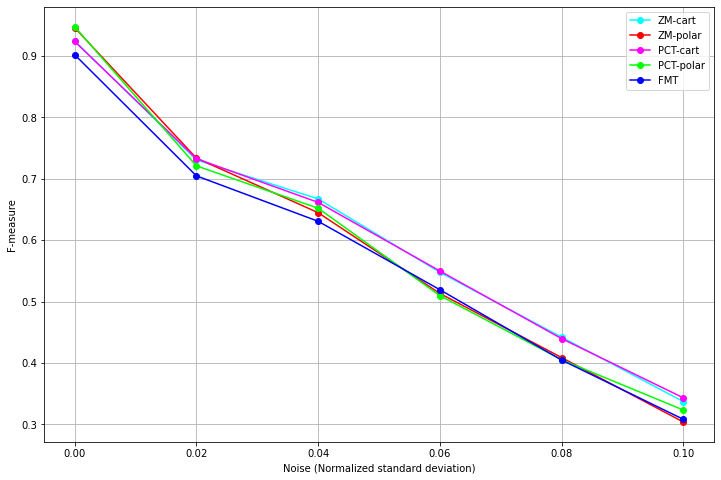

In [4]:
plt.figure(figsize=(12,8))
for j in range(5):
    plt.plot(
        [0]+noise_values,
        np.concatenate(([fscores_mean_translation[j]],fscores_mean_noise[:,j]),0),
        'o-',
        color=colors[j],
        label=methods[j]
    )
plt.legend()
plt.xlabel('Noise (Normalized standard deviation)')
plt.ylabel('F-measure')
plt.grid(True)
plt.show()

**Curve from the article**

<img align='left' src="example_images/noise.png" alt="drawing" width="400"/>

### Rotation

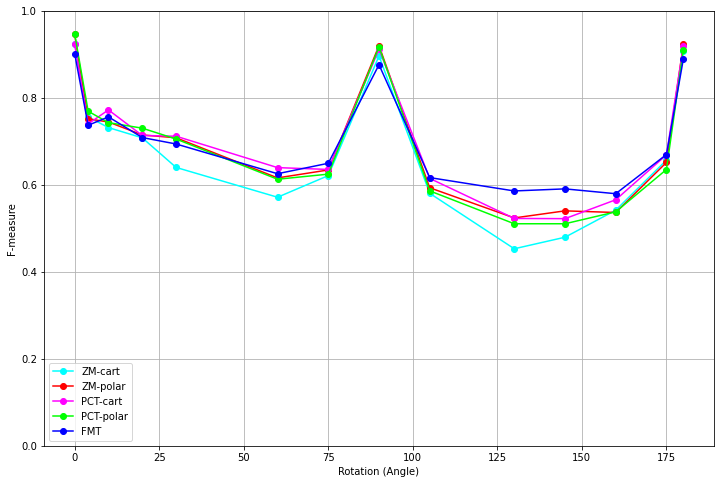

In [5]:
plt.figure(figsize=(12,8))
for j in range(5):
    plt.plot(
        [0]+angle_values,
        np.concatenate(([fscores_mean_translation[j]],fscores_mean_rotate[:,j]),0),
        'o-',
        color=colors[j],
        label=methods[j]
    )
plt.legend()
plt.xlabel('Rotation (Angle)')
plt.ylabel('F-measure')
plt.ylim([0, 1])
plt.grid(True)
plt.show()

**Curve from the article**

<img align="left" src="example_images/rotation.png" alt="drawing" width="400"/>

### Resizing

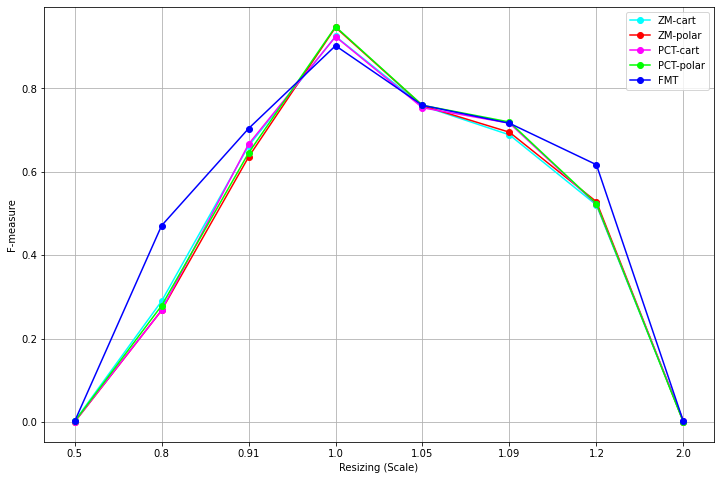

In [6]:
plt.figure(figsize=(12,8))
for j in range(5):
    plt.plot(
        np.array(scale_values[:3]+[1.0]+scale_values[3:]).astype(str),
        np.concatenate((fscores_mean_scale[:3,j],[fscores_mean_translation[j]],fscores_mean_scale[3:,j]),0),
        'o-',
        color=colors[j],
        label=methods[j]
    )
plt.legend()
plt.xlabel('Resizing (Scale)')
plt.ylabel('F-measure')
plt.grid(True)
plt.show()

**Curve from the article**

<img align="left"  src="example_images/resizing.png" alt="drawing" width="400"/>

### JPEG compression

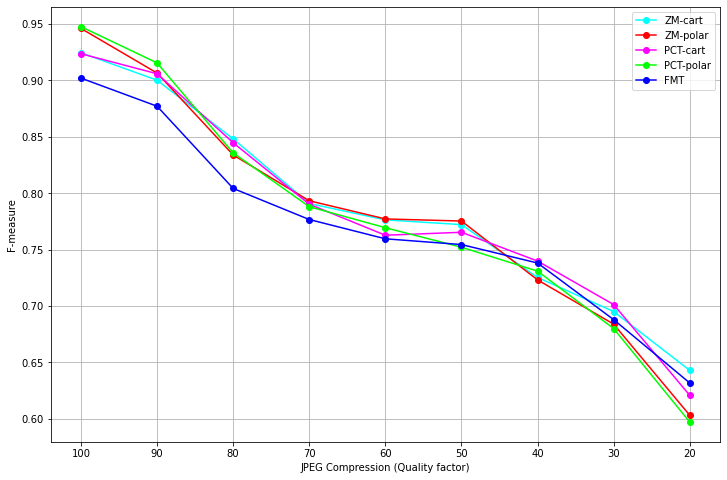

In [7]:
plt.figure(figsize=(12,8))
for j in range(5):
    plt.plot(
        np.array([100]+jpeg_values).astype(str),
        np.concatenate(([fscores_mean_translation[j]],fscores_mean_jpeg[:,j]),0),
        'o-',
        color=colors[j],
        label=methods[j]
    )
plt.legend()
plt.xlabel('JPEG Compression (Quality factor)')
plt.ylabel('F-measure')
plt.grid(True)
plt.show()

**Curve from the article**

<img align="left"  src="example_images/jpeg.png" alt="drawing" width="400"/>

For every degradation, we managed to reproduce well the curves from the article. From these curves, we can make several observations :
 - the 5 features got similar results. We can also notice that the Fourier-Mellin Transform gives slightly better results for scaling
 - the F-score decreases linearly with the AWGN and the JPEG compression. Yet, the F-score remains good for moderate noise and compression
 - for the rotation, the F-score remains always pretty good, with peaks every 90 degrees where we reach similar performance as if there were no transformation. We observe that we get slightly worse results than in the paper, but this is probably due to the opencv library used to realize the rotation of the patch in our implementation.
 - the performance for resizing drops very fast, reaching 0 very quickly

On the whole, the algorithm is rather robust against moderate degradations. The only exception is the scaling for which the performance drop quickly. 

In the following, we propose a complementary method to improve detection performance in some particular cases.

## 3) Complementary approach 

In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from utilities import *
from scipy.ndimage.filters import gaussian_filter
from tqdm import tqdm
import os

## How can we determine if an image is forged?

We have just seen that the patchmatch algorithm succesfully identifies forged images in a restricted context. In particular, it performs poorly when the patches are resized with a large factor, and it is unable to detect inserted patches from other images. Our aim is to extend this method to better deal with these two situations.

In a forged image, the modified regions should differ in some ways from the unmodified ones. We are looking for a way to spot these differences in order to identify the modifications. However, using the local parameters of an image (value, contrast, sharpness, white-balance...) to spot inconsistencies doesn't work because the former vary drastically, even inside unmodified images:

<img src="example_images/sq_an.jpg" alt="drawing" width="400"/>
<img src="example_images/bike_an.jpg" alt="drawing" width="400"/>
<img src="example_images/chic_an.jpg" alt="drawing" width="400"/>
<img src="example_images/int_an.jpg" alt="drawing" width="400"/>


(source: Pixabay.fr)

Lens blur and motion blur can produce different levels of sharpness. Moreover, the existence of several light sources can modify the white-balance around them, and even contrast varies across the different parts of the image...  

On the other hand, noise almost only depends on the values of the photographed objects: it should be consistent across the whole image. And that is why it can be used as a means of image forgery detection. The main difficulty is to estimate it accurately by separating it from the natural variations of the image. This is what we will explore now.

## A study of the local variance of a forged image

Consider the following forged image:

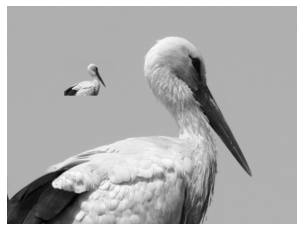

In [9]:
im = load_tensor_img("forged_images/cyg.png") ; plt.imshow(im, cmap='gray') ; plt.axis('off'); plt.show()

We can see that it contains a rescaled (rectangle) duplicate of itself. The sky region is smooth, so the rescaled portion should have less noise. 

Indeed, if $u(i,j)$ is a pixel of the sky (which is considered uniform of color $c \in [0,255]^3$), we have:
$$u(i,j) = c+\sigma n(i,j)  \text{, where } n(i,j )\sim \mathcal{N}(0,1)$$

If we resize the image by a factor 3, each pixel of the resized image will be an average of 9 pixels of the original image:
$$v(i,j) = \frac{1}{9} \sum_{ \substack{ i\leq k < i+3 \\ j\leq l < j+3}} u(k,l)$$

We thus have $\mathbb{E}(v) = \mathbb{E}(u) = c$ and  $\mathbb{V}(v) = \mathbb{V}(u)/9 = \sigma^2/9$. The new image can be expressed via:
$$v(i,j) = c+\frac{\sigma}{3} n'(i,j)  \text{, where } n'(i,j )\sim \mathcal{N}(0,1)$$


The noise should thus be reduced by a factor 3. If we compute the standard deviation of 8x8 blocks, we obtain:

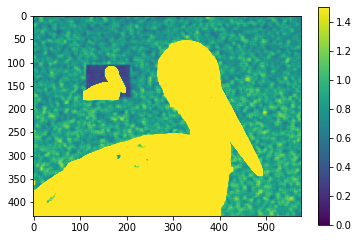

In [10]:
k=8 ; n,m = im.shape ; std = np.zeros((n-k,m-k))
for i in range(0,n-k):
    for j in range(0,m-k):
        std[i,j]=im[i:i+k,j:j+k].std()
plt.imshow(std, vmin=0, vmax=1.5) ; plt.colorbar() ; plt.imsave('forged_images/var.png', std, vmin=0, vmax=1.5); plt.show()


In [11]:
std[108:108+20, 117:117+20].mean()/std[:20, :20].mean()

0.35937798209915695

As expected, the measured standard deviation in the resized portion is reduced by a factor $\sim 3$. The same phenomenon happens when upscaling a portion of the image:

Let us consider an upscale of factor $2$ via a bilinear interpolation, and a $4 \times 4$ patch $(u(i,j), u(i+1,j), u(i,j+1), u(i+1,j+1))$ of the original image. It becomes a $16 \times 16$ patch with $4$ pixels corresponding with unchanged values, $8$ pixels average of two values, and $4$ pixels average of four values. 
The variance becomes: 
$$\mathbb{V}(v) = \frac{4}{16}\mathbb{V}(u) + \frac{8}{16} \frac{1}{2}\mathbb{V}(u) + \frac{4}{16} \frac{1}{4}\mathbb{V}(u) = \frac{9}{16} \mathbb{V}(u)$$

If we have a patch upcaled by a factor 4, the variance is multiplied by $81/256$ and the standard deviation by $9/16 = 0.5625$

An almost invisible modification can verify this:

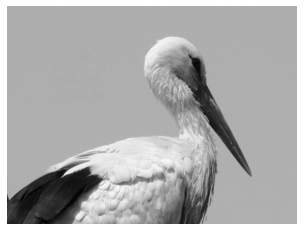

In [12]:
im = load_tensor_img("forged_images/cyg_up.png") ; plt.imshow(im, cmap='gray') ; plt.axis('off'); plt.show()

Computing the variance allows us to spot the forged region:

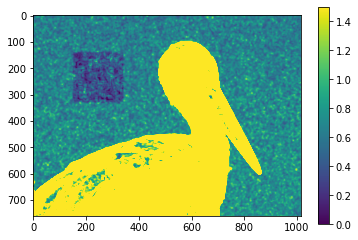

In [13]:
k=8 ; n,m = im.shape ; std = np.zeros((n-k,m-k))
for i in range(0,n-k):
    for j in range(0,m-k):
        std[i,j]=im[i:i+k,j:j+k].std()
plt.imshow(std, vmin=0, vmax=1.5) ; plt.colorbar() ;plt.show()

In [14]:
std[200:200+20, 200:200+20].mean()/std[:20, :20].mean()

0.6065028892758741

The measured standard deviation in the resized portion is indeed reduced by a factor $\sim 16/9$.

We have just seen that upscaling or downscaling patches in natural images changes the standard deviation of the noise in uniform regions. However, computing the patch standard deviation does not always allow spotting the forged sections of the image as it can vary even inside the unmodified regions (for instance, it is higher in the highly textured regions of the image). 

Luckily, there does exist a way to estimate noise (and not just variance) and this is what we will examine in the next section.

## Image noise estimation 

In this section we implemented the following paper:

[*Analysis and Extension of the Ponomarenko et al. Method, Estimating a Noise Curve from a Single Image*, Miguel Colom, Antoni Buades (2013)](https://www.ipol.im/pub/art/2013/45/) [1]

It's based on a model in which the noise standard deviation $\sigma$ only depends on the value of the pixel. The idea is to compute the DCT decomposition of 8x8 patches, and use that to estimate noise: the first coefficients represent variations in the image (due to edges, corners, texture..), and the last ones account for noise.

The algorithm is the following:

- For mean intensity $c$ in a given range:
    - Select 8x8 blocks of mean intensity $c$
    - Compute their DCT decompositions
    - Sort them with respect to their first 16 coefficients
    - Select the first portion of size $f$
    - Estimate the noise with the larger coefficients
    
We implemented this algorithm in PyTorch.

### Image noise estimation: Pytorch noise estimation

Model DCT basis:


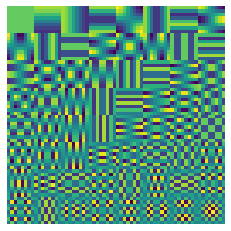

In [15]:
def dct_basis(n, k1, k2):
    x = np.array([range(n)])
    x = 2 * np.cos(np.pi * (2 * x + 1) * k1 / 2.0 / n)
    red1 = 1 / np.sqrt(2) if k1 == 0 else 1

    y = np.array([range(n)])
    y = 2 * np.cos(np.pi * (2 * y + 1) * k2 / 2.0 / n)
    red2 = 1 / np.sqrt(2) if k2 == 0 else 1

    return np.dot(x.T, y) * red1 * red2 / 2 / n


class DCT_CONV(nn.Module):
    def __init__(self, ksize=8, T=36):
        """ k: kernel size
            T: number of first coefficients used"""
        super(__class__, self).__init__()

        dtype = torch.FloatTensor
        if torch.cuda.is_available():
            dtype = torch.cuda.FloatTensor
        self.ksize = ksize
        ch = ksize ** 2

        self.T = T

        self.padding = nn.ReflectionPad2d(2 * ksize // 2 - 1)

        self.conv_dct = nn.Conv2d(
            in_channels=1,
            out_channels=ch,
            kernel_size=ksize,
            stride=1,
            padding=0,
            bias=False,
        )

        indices = [(i % ksize, i // ksize) for i in range(ch)]
        indices.sort(key=lambda e: e[0] + e[1])
        for ind, i in zip(indices, range(ch)):
            a1 = dct_basis(ksize, ind[0], ind[1])
            self.conv_dct.weight.data[i, 0, :, :] = nn.Parameter(dtype(a1))

    def forward(self, x):
        """ input: H x W  image
            output: k^2 x H x W dct coefficients"""
        out = self.conv_dct(self.padding(x[None, None, :, :]))
        return out[0]

    def mean_dct(self, output):
        """mean of the smoothed output (kxk filter)"""
        return output[0, :, :] / self.ksize

    def lowfreq_var(self, output):
        """low_frequency variance, first T coefficients"""
        low_freq = output[1 : self.T, :, :] ** 2  # exclude mean
        low_freq = torch.sum(low_freq, dim=0) / (self.T - 1)
        return low_freq

    def highfreq_var(self, output):
        """low_frequency variance, first T coefficients"""
        low_freq = output[self.T :, :, :] ** 2  # exclude mean
        low_freq = torch.sum(low_freq, dim=0) / (self.ksize ** 2 - self.T)
        return low_freq

    def noise_var(
        self, output, mean_dct, lowfreq_var, low_val, high_val, f_var=0.01, median=True
    ):
        """returns relevant noise variance when image value is between low_val and high_val
            f_var: fractions used to estimate noise"""
        # select image values between low_val and high_val
        mean_mask = (mean_dct < high_val) * (mean_dct >= low_val)

        # Select small low_frequency variances (~uniform patches)
        lowf_variances = torch.masked_select(lowfreq_var, mean_mask)
        if lowf_variances.size()[0] == 0:
            return None
        tresh = torch.quantile(lowf_variances, f_var)
        lowf_mask = (lowfreq_var <= tresh) * mean_mask

        # mask the corresponding pixels
        high_freq = (output[self.T :] * lowf_mask) ** 2
        high_freq = torch.sum(high_freq, dim=(1, 2)) / torch.sum(
            lowf_mask
        )  # mean of the variances [ksize**2 - T] vector
        if median:
            return torch.median(high_freq)
        return high_freq

    def image_variance_hist(self, x, e_per_bin=40000, f_var=0.01):
        """ input: [H,W] tensor
            output: variance histogram"""

        # compute DCT transforms, dim [ksize**2, H, W]
        output = self.forward(x)

        # compute image mean values
        mean_dct = self.mean_dct(output)  # dim [H, W]
        mean_list = mean_dct.flatten().sort()[0]

        # compute lowfreq_var
        lowfreq_var = self.lowfreq_var(output)  # dim [H, W]

        Lmeans = []
        Lvars = []
        if e_per_bin < len(mean_list):
            for index in range(0, len(mean_list), e_per_bin):
                low_val = mean_list[index]
                high_val = mean_list[min(index + e_per_bin, len(mean_list) - 1)]
                this_var = self.noise_var(
                    output, mean_dct, lowfreq_var, low_val, high_val, f_var
                )
                if not (this_var is None):
                    Lmeans.append((high_val + low_val).item() / 2)
                    Lvars.append(this_var.item())
        return Lmeans, Lvars

    def show_net(self):
        out_img = np.zeros((self.ksize ** 2, self.ksize ** 2))
        for i in range(self.ksize ** 2):
            x = i // self.ksize
            y = i % self.ksize
            out_img[
                x * self.ksize : (x + 1) * self.ksize,
                y * self.ksize : (y + 1) * self.ksize,
            ] = self.conv_dct.weight.data[i, 0, :, :]
        plt.imshow(out_img)
        im = Image.fromarray(out_img)
        im = im.resize((640,640), Image.NEAREST)
        plt.imsave('forged_images/DCT.png', im);
        plt.axis("off")
        plt.show()
        
M = DCT_CONV(ksize=8)
print("Model DCT basis:")
M.show_net()

### Image noise estimation: Noise curve extraction

Convolving the image with the first 16 DCT elements gives us the low frequency variance:

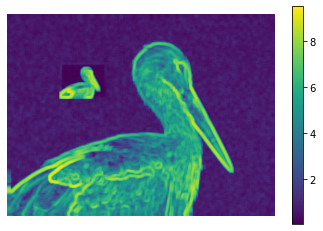

In [16]:
im = load_tensor_img("forged_images/cyg.png")
out = M.lowfreq_var(M(im))
plt.imshow(np.log(1+out.detach().numpy())); plt.axis('off'); plt.colorbar(); 
plt.imsave('forged_images/lowfreq.png',np.log(1+out.detach().numpy()));
plt.show()

Convolving the image with the remaining DCT elements gives us the low frequency variance:

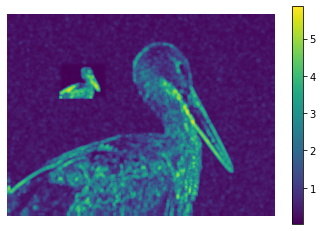

In [17]:
out = M.highfreq_var(M(im))
plt.imshow(np.log(1+out.detach().numpy())); plt.axis('off'); plt.colorbar();
plt.imsave('forged_images/highfreq.png', np.log(1+out.detach().numpy()));
plt.show()

By combining these two informations, we can estimate a noise curve:

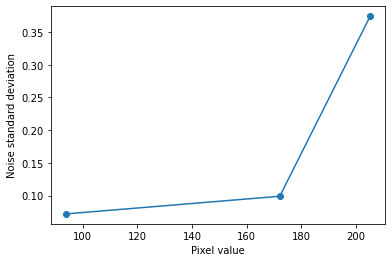

In [18]:
Lm,Lv= M.image_variance_hist(im, e_per_bin=100000, f_var=0.005)
plt.plot(Lm,Lv,'o-'); plt.xlabel("Pixel value"); plt.ylabel("Noise standard deviation"); plt.savefig('forged_images/noise curve.png'); plt.show()

Note that the noise is only estimated for certain values which are frequent in the image (here the values are $95, 175, 210$). 
Now that we can estimate noise, we can look for inconsistencies in the image.

## From noise estimation to forgery detection

In this section we took inspiration in the following paper:

[*Forgery Detection in Digital Images by Multi-Scale Noise Estimation*, Marina Gardella, Pablo Musé, Jean-Michel Morel and Miguel Colom (2021)](https://www.mdpi.com/2313-433X/7/7/119/htm) [2]

The idea is to compute the noise curve estimation of the whole image and of each 64x64 patch. If the noise curve of a patch is noticeably lower than the curve of the whole image, the patch is suspicious. 

The algorithm is:

- Compute the image noise curve $L$
- Create local score array $local\_score$
- For each patch of size 8x8:
    - Compute the patch noise curve $L_p(i,j)$
    - Compute the curve score $local\_score(i,j) = sc(L,L_p(i,j))$
- Create output array $suspicious\_pixels$
- If there exists $(i_0,j_0)$ s.t. $sc(L,L_p(i_0,j_0)) > 0.1$:
    - Blur the local score with a gaussian kernel $blurred(i,j) = blur(local\_score)$ 
    - Let $m = max(blurred)$
    - Let $suspicious\_pixels(i,j) = \mathbb{1}_{blurred(i,j) > m*0.5}$
- return $suspicious\_pixels$


In the paper [2], the curve score represents the number of bins in which the noise of the patch is lower than the image noise. This works for high resolution images, but not for small images. We implemented a custom metric (called `curve_score` in *utilities.py*), which measures the relative intesity of the histogram curves: a score of $0.2$ means that the patch noise curve is $20\%$ lower than the full noise curve. We also found that bluring the score_array with a gaussian kernel optimizes the $f1$ score of the detected forgery.


Let's compute the noise 'curve' of a forged patch (which is rather an estimate of the noise for several frequent values):

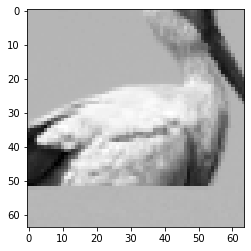

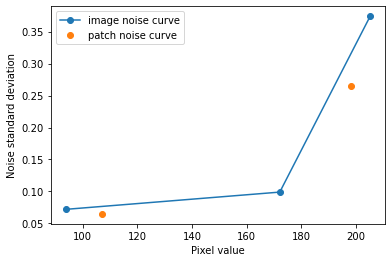

Patch score: 0.1624715405231012


In [19]:
im = load_tensor_img("forged_images/cyg.png")
patch = im[2*64:2*64+64, 2*64:2*64+64]; plt.imshow(patch, cmap='gray'); plt.show()
Lm2,Lv2= M.image_variance_hist(patch, e_per_bin=3000, f_var=0.1)
plt.plot(Lm,Lv,'o-', label="image noise curve" )
plt.plot(Lm2,Lv2,'o', label="patch noise curve"); plt.legend(); plt.xlabel("Pixel value"); plt.ylabel("Noise standard deviation"); plt.savefig('forged_images/patch noise curve.png'); plt.show()
print("Patch score:", curve_score(Lm,Lv,Lm2,Lv2))

Note that the orange dots are below the blue line: the noise is suspiciously low. We can now compute the score for each patch of the original image:

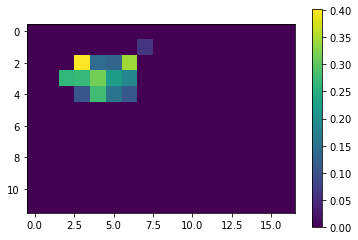

In [20]:
percent_wrong = compute_suspicious_pixels(M, im)
plt.imshow(percent_wrong); plt.colorbar(); plt.savefig('forged_images/score.png'); plt.show()

If the image contains a patch of score > 0.1, we consider that it is forged. We blur the score image:

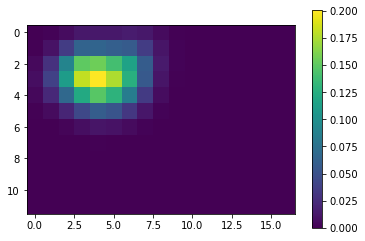

In [21]:
blured=gaussian_filter(percent_wrong, 1)
plt.imshow(blured); plt.colorbar();  plt.savefig('forged_images/score2.png'); plt.show()

And select the forged regions with a certain treshold:

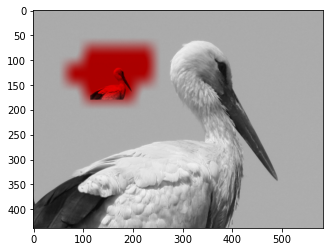

In [22]:
out_m = (blured>blured.max()*0.5)
plt.imshow(show_heat_map(im,out_m)); plt.savefig('forged_images/score3.png');  plt.show()

Success! The forged region has been identified in less than $3$ seconds. Let's try this on an another forged image, with a given modification mask:

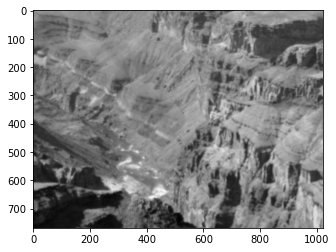

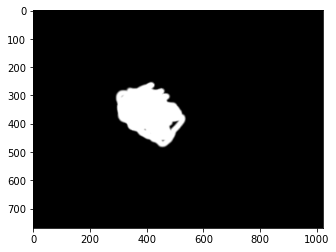

In [23]:
im = load_tensor_img("CMFDdb_grip/scale1.5/IMG_C01_008_1.5_copy.png")
mask = np.array(Image.open("CMFDdb_grip/scale1.5/IMG_C01_008_1.5_gt.png"))
plt.imshow(im, cmap='gray') ; plt.show() ;plt.imshow(mask, cmap='gray'); plt.show()

This is the result given by the original paper [2]:

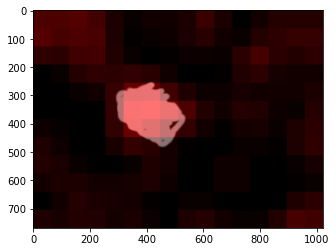

F-score: 0.46382243837462345


In [24]:
mask_morel = np.array(Image.open("MorelResult/scale1.5/6.png"))/255.0
plt.imshow(show_heat_map(mask,mask_morel, "MASK")) ; plt.show()
print("F-score:", Fmeasure(mask, mask_morel))

This is ours:

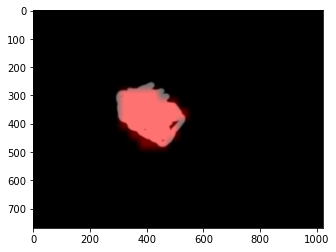

F-score: 0.8725335713190077


In [25]:
percent_wrong = compute_suspicious_pixels(M, im)
blured=gaussian_filter(percent_wrong, 1)
out_m = (blured>blured.max()*0.5)
plt.imshow(show_heat_map(mask,out_m, "MASK")) ; plt.show()
print("F-score:", Fmeasure(mask, out_m))

## Forgery detection on the benchmark dataset

In [26]:
folder='scale1.5/'
files = os.listdir('CMFDdb_grip/'+folder)
files.sort()
def alexis_image(i):
    return 'CMFDdb_grip/'+folder+files[2*i]
def alexis_mask(i):
    return 'CMFDdb_grip/'+folder+files[2*i+1]


def morel_find(i):
    return "MorelResult/"+folder+str(i)+".png"

In [27]:
#TO COMPUTE THE SCORE ON THE DATASET

fms=[]
for k_im in tqdm(range(len(files)//2)):
    mask = np.array(Image.open(alexis_mask(k_im)))
    
    # original paper
    # out_m = np.array(Image.open(morel_find(k_im)))/255.0
    # flat 
    out_m = np.ones_like(out_m)

    # custom score 
    # im = load_tensor_img(alexis_image(k_im))
    # percent_wrong = compute_suspicious_pixels(M, im, 64, 1500, 0.3)
    # blured = gaussian_filter(percent_wrong, 1) # Gaussian filtering
    # if blured.max()>0.1:
    #     out_m = blured>blured.max()*0.5
    # else:
    #     out_m = np.zeros_like(blured)

    fms.append(Fmeasure(mask,out_m)) 
sum(fms)/len(fms)

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 36.14it/s]


0.0896658272905041

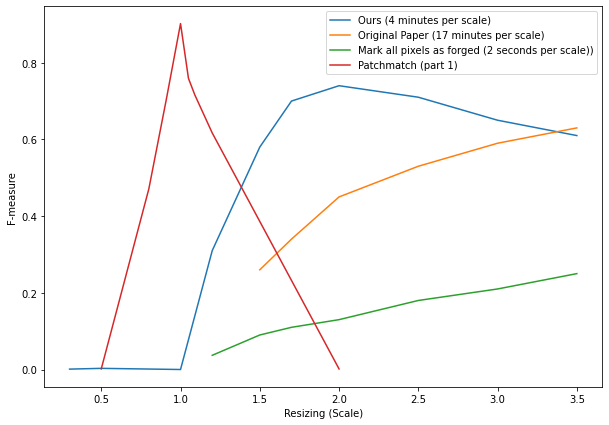

In [28]:
scales = [0.3, 0.5, 1, 1.2, 1.5, 1.7, 2, 2.5, 3, 3.5]
fmb=[0.001, 0.003,0.00,  0.31, 0.58, 0.70, 0.74, 0.71, 0.65, 0.61]

scales_paper = [1.5, 1.7, 2, 2.5, 3, 3.5]
original_paper=[0.26, 0.34, 0.45, 0.53, 0.59, 0.63]

scales_flat = [1.2, 1.5, 1.7, 2, 2.5, 3, 3.5]
original_flat=[0.037, 0.09, 0.11, 0.13, 0.18, 0.21, 0.25]


patch_matchx= [0.5,  0.8 , 0.91 ,1.  , 1.05, 1.09, 1.2 , 2.  ]
patch_matchy = [0.001604  , 0.4708068 , 0.70350068, 0.90202244 ,0.75920497 ,0.71615537, 0.61679327 ,0.00150403]


plt.figure(figsize=(10,7))
plt.plot(scales, fmb, label="Ours (4 minutes per scale)")
plt.plot(scales_paper, original_paper, label="Original Paper (17 minutes per scale)")

plt.plot(scales_flat, original_flat, label="Mark all pixels as forged (2 seconds per scale))")

plt.plot(patch_matchx, patch_matchy, label="Patchmatch (part 1)")
plt.xlabel('Resizing (Scale)')
plt.ylabel('F-measure')
plt.legend()
plt.savefig('forged_images/global results.png')

plt.show()

We tested three different methods: the method of the original paper [2], ours, and a simple one where every pixel is marked as suspicious. 

Our method is 4 times faster than [2], and could be even faster if ran on a GPU. Interestingly, its performances decrease when the scale is too large. We believe it's because in this setting each resized patch almost covers the whole image, and thus hinders the noise estimation process. The method described in the paper uses a multi-scale estimation which performs better in this setting. Another unexpected behaviour happends when the scale is inferior to $1$, and almost no pixels are detected. We believe it's because the modified patches are too small and disappear in the smoothing step. 

In any case, this algorithm completes the patchmatch approach: it performs well with rescaled images.

## Another application: test on inserted patches

We also tested our method on *photomontages*, with inserted elements from different images:



<img src="forged_images/Montages/hare.jpg" alt="drawing" width="400"/>
<img src="forged_images/Montages/hare_p.jpg" alt="drawing" width="400"/>
<img src="forged_images/Montages/citr.jpg" alt="drawing" width="400"/>
<img src="forged_images/Montages/citr_p.jpg" alt="drawing" width="400"/>
<img src="forged_images/Montages/kang.jpg" alt="drawing" width="400"/>
<img src="forged_images/Montages/kang_p.jpg" alt="drawing" width="400"/>


<img src="forged_images/forest_rhino.png" alt="drawing" width="400"/>
<img src="forged_images/forest_rhino_ours.png" alt="drawing" width="400"/>
<img src="forged_images/desert.jpg" alt="drawing" width="400"/>
<img src="forged_images/desert_p.png" alt="drawing" width="400"/>

The results vary a lot. We identified a few factors that lead to incorrect detections:
- When the image is highly compressed: if the noise is eliminated, the whole process fails
- When the inserted patch values aren't present in the original image: in that case, the noice inconsistencies cannot be identified.
- When some regions of the images are over-exposed or under-exposed: in that case, the noised is compressed in the blown-outs regions and they are identified as suspect.

We also tested the robstuness of our approach on different transformations of the forged image:

Rescale of factor 50%:

<img src="forged_images/cyg_rs2.png" alt="drawing" width="400"/>
<img src="forged_images/cyg_rs2_out.png" alt="drawing" width="400"/>

Rescale of factor 70%:

<img src="forged_images/cyg_rs.png" alt="drawing" width="400"/>
<img src="forged_images/cyg_rs_out.png" alt="drawing" width="400"/>

Blur:

<img src="forged_images/cyg_blur.png" alt="drawing" width="400"/>
<img src="forged_images/cyg_blur_out.png" alt="drawing" width="400"/>

Color modifications:

<img src="forged_images/cyg_saturation.png" alt="drawing" width="400"/>
<img src="forged_images/cyg_saturation_out.png" alt="drawing" width="400"/>

Provided the transformation is not too severe, the forged region is identified.

## Conclusion

To conclude the PatchMatch algorithm provides an efficient method to detect and localize Copy-Move forgeries in images. Its scalability allows to use any features of the literature and notably scale and rotation invariant features. As a direct consequence, the algorithm obtains very good results for different degradations of the forged patches. However, its performance drop for large values of degradation, and in particular for resized patches.

The patchmatch algorithm can be extented to better work on scaled patches with the method described in [4]. We implemented a faster version on PyTorch with a new score (to better work on small images) and a blurring step (to optimize the $f1$ score). In some cases, this method succesfully spots inserted objects from other images. 

Image forgery can be done in various ways, and we only covered a portion of this vast subject. Our work could be further extended by a deeper analysis of non organic additions in images and local image modifications (blurring, deformations..etc.).

## Bonus


Try the code on your own images!

Input image:


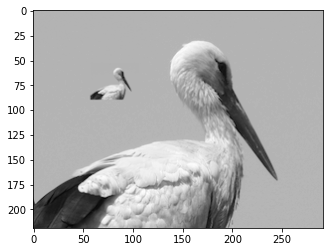

Suspicious pixels:


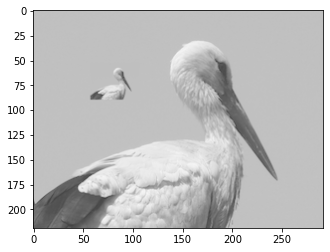

In [29]:
IMG_PATH = "forged_images/cyg_rs2.png"
SAVE_OUTPUT = True

im = load_tensor_img(IMG_PATH)
print('Input image:')
plt.imshow(im, cmap='gray') ; plt.show() 

percent_wrong = compute_suspicious_pixels(M, im)
blured=gaussian_filter(percent_wrong, 1)
out_m = (blured>blured.max()*0.5)
print('Suspicious pixels:')
plt.imshow(show_heat_map(im,out_m))
if SAVE_OUTPUT:
    plt.imsave(IMG_PATH[:-4]+'_out.png', show_heat_map(im,out_m).detach().numpy())
plt.show()